# Using Centroids to Filter Ookla Performance Tiles and Aggregating Loaded Latency

This tutorial will show how to filter Ookla Global Performance Map Tiles to a specific area by using centroid coordinates.

In [63]:
%matplotlib inline

from datetime import datetime

# Force GeoPandas pre version 0.14 to use Shapely by default instead of PyGEOS
import os
os.environ['USE_PYGEOS'] = '0'

import sys
print("Python version:", sys.version)

import geopandas as gp
print("GeoPandas version:", gp.__version__)
import matplotlib
print("matplotlib version: ", matplotlib.__version__)
import matplotlib.pyplot as plt
import pandas as pd
print("Pandas version:", pd.__version__)
import numpy as np
print("Numpy version: ", np.__version__)

import shapely
from shapely import wkt
print("Shapely version: ", shapely.__version__)
from shapely.geometry import Point, Polygon, MultiPolygon

from scipy.spatial import cKDTree

import networkx as nx
print("NetworkX version: ", nx.__version__)

import osmnx as ox
print("OSMNX version: ", ox.__version__)
import os
from stat import S_ISDIR

#ox.settings.use_cache = True
from adjustText import adjust_text


Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
GeoPandas version: 0.14.3
matplotlib version:  3.8.0
Pandas version: 2.2.1
Numpy version:  1.26.4
Shapely version:  2.0.2
NetworkX version:  3.1
OSMNX version:  1.9.2


## Download data

We will be using the state of Michigan for this example.

In [2]:
STATE_FIPS_MI = '26'
TIGER_COUNTIES_URL = "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"

#Ookla data
def get_perf_tiles_parquet_url(service: str, year: int, quarter: int) -> str:
    quarter_start = f"{year}-{(((quarter - 1) * 3) + 1):02}-01"
    url = f"s3://ookla-open-data/parquet/performance/type={service}/year={year}/quarter={quarter}/{quarter_start}_performance_{service}_tiles.parquet"
    return url


# Zipfile of U.S. county boundaries
counties = gpd.read_file(TIGER_COUNTIES_URL)
# Filter out the MI fips code and reproject to match the tiles
state_counties_gdf = counties.loc[counties['STATEFP'] == STATE_FIPS_MI].to_crs(4326)
# Capture the total bounds of the state's counties
state_bounds = state_counties_gdf.total_bounds

In [53]:
state_bounds

array([-90.41839527,  41.69611767, -82.122971  ,  48.306063  ])

We'll also establish our metric name that we'll use later on. In this case we're focusing on average download latency (which is in milliseconds). 

In [45]:
metric_name = 'avg_lat_down_ms'
perf_tiles_url = get_perf_tiles_parquet_url("fixed", 2023, 3)

## Filter data using a bounding box of specified area

We'll create the box using the state boundaries from earlier.

In [4]:
bbox_filters = [('tile_y', '<=', state_bounds[3]), ('tile_y', '>=', state_bounds[1]),
                ('tile_x', '<=', state_bounds[2]), ('tile_x', '>=', state_bounds[0])]

The most crucial step: by only specifying the columns we need and filtering, this loads only the data we care about in a very performant fashion.

In [7]:
# tiles_df = pd.read_parquet(perf_tiles_url,
#                            columns=['tile_x', 'tile_y', 'tests', metric_name],
#                            filters=bbox_filters,
#                            storage_options={"s3": {"anon": True}}
#                            )

In [46]:
tiles_df = pd.read_parquet(perf_tiles_url,
                           filters=bbox_filters,
                           storage_options={"s3": {"anon": True}}
                           )

In [47]:
tiles_df['quarter'] = '2023Q3'

We can now establish a geodataframe with the subset of OFG tile data. 

In [48]:
tiles_gdf = gpd.GeoDataFrame(tiles_df, geometry=gpd.points_from_xy(tiles_df.tile_x, tiles_df.tile_y), crs="EPSG:4326").drop(columns=["quadkey", "tile", "tile_x", "tile_y"])
# Drop any rows where we're missing values for the metric
#tiles_gdf.dropna(subset=[metric_name], inplace=True)

In [49]:
points_gdf = pd.concat([points_gdf, tiles_gdf])

In [55]:
points_gdf = points_gdf[['quarter', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms',
       'avg_lat_up_ms', 'tests', 'devices', 'geometry']]

In [68]:
points_gdf

,quarter,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,geometry
0,2024Q1,57158,92750,14,35.0,1949.0,1,1,POINT (-90.38180 48.06890)
1,2024Q1,129261,212616,13,73.0,133.0,17,2,POINT (-90.37080 48.07620)
2,2024Q1,19085,18921,16,24.0,18.0,2,1,POINT (-90.37080 48.06160)
3,2024Q1,93150,32015,19,341.0,603.0,3,1,POINT (-90.40920 48.03590)
4,2024Q1,91871,99315,16,203.0,537.0,4,4,POINT (-90.40370 48.03590)
...,...,...,...,...,...,...,...,...,...
123965,2023Q3,91331,6719,75,153.0,89.0,4,1,POINT (-82.62540 41.76520)
123966,2023Q3,43865,3285,59,294.0,103.0,1,1,POINT (-82.62540 41.76110)
123967,2023Q3,27482,3813,60,308.0,138.0,4,1,POINT (-82.62540 41.75700)
123968,2023Q3,45210,14667,42,255.0,128.0,1,1,POINT (-82.64190 41.74470)


In [65]:
points_gdf.to_file('MI_Netstats.gpkg', driver="GPKG")

ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: failed to execute insertion in RTree : disk I/O error
ERROR 1: sqlite3_exec(ROLLBACK) failed: cannot rollback - no transaction is active


In [66]:
#data = gpd.read_file('MI_Netstats.gpkg')

In [67]:
#data

,quarter,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,geometry
0,2024Q1,57158,92750,14,35.0,1949.0,1,1,POINT (-90.38180 48.06890)
1,2024Q1,129261,212616,13,73.0,133.0,17,2,POINT (-90.37080 48.07620)
2,2024Q1,19085,18921,16,24.0,18.0,2,1,POINT (-90.37080 48.06160)
3,2024Q1,93150,32015,19,341.0,603.0,3,1,POINT (-90.40920 48.03590)
4,2024Q1,91871,99315,16,203.0,537.0,4,4,POINT (-90.40370 48.03590)
...,...,...,...,...,...,...,...,...,...
351312,2023Q3,91331,6719,75,153.0,89.0,4,1,POINT (-82.62540 41.76520)
351313,2023Q3,43865,3285,59,294.0,103.0,1,1,POINT (-82.62540 41.76110)
351314,2023Q3,27482,3813,60,308.0,138.0,4,1,POINT (-82.62540 41.75700)
351315,2023Q3,45210,14667,42,255.0,128.0,1,1,POINT (-82.64190 41.74470)


## Perform a spatial join to counties of Michigan

Now that the dataset is smaller, this join will be easier to perfom. We purposefully use an inner join to only keep tiles that intersect with counties. We'll add the county polygons back in later.

In [58]:
counties_tiles_gdf = gpd.sjoin(points_gdf, state_counties_gdf,
                               how="inner", 
                               predicate="intersects")[['quarter', 'GEOID', 'avg_d_kbps',
                                                        'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms',
                                                        'avg_lat_up_ms', 'tests', 'devices', 'geometry']]

#[['GEOID', 'tests', metric_name]]

<Axes: >

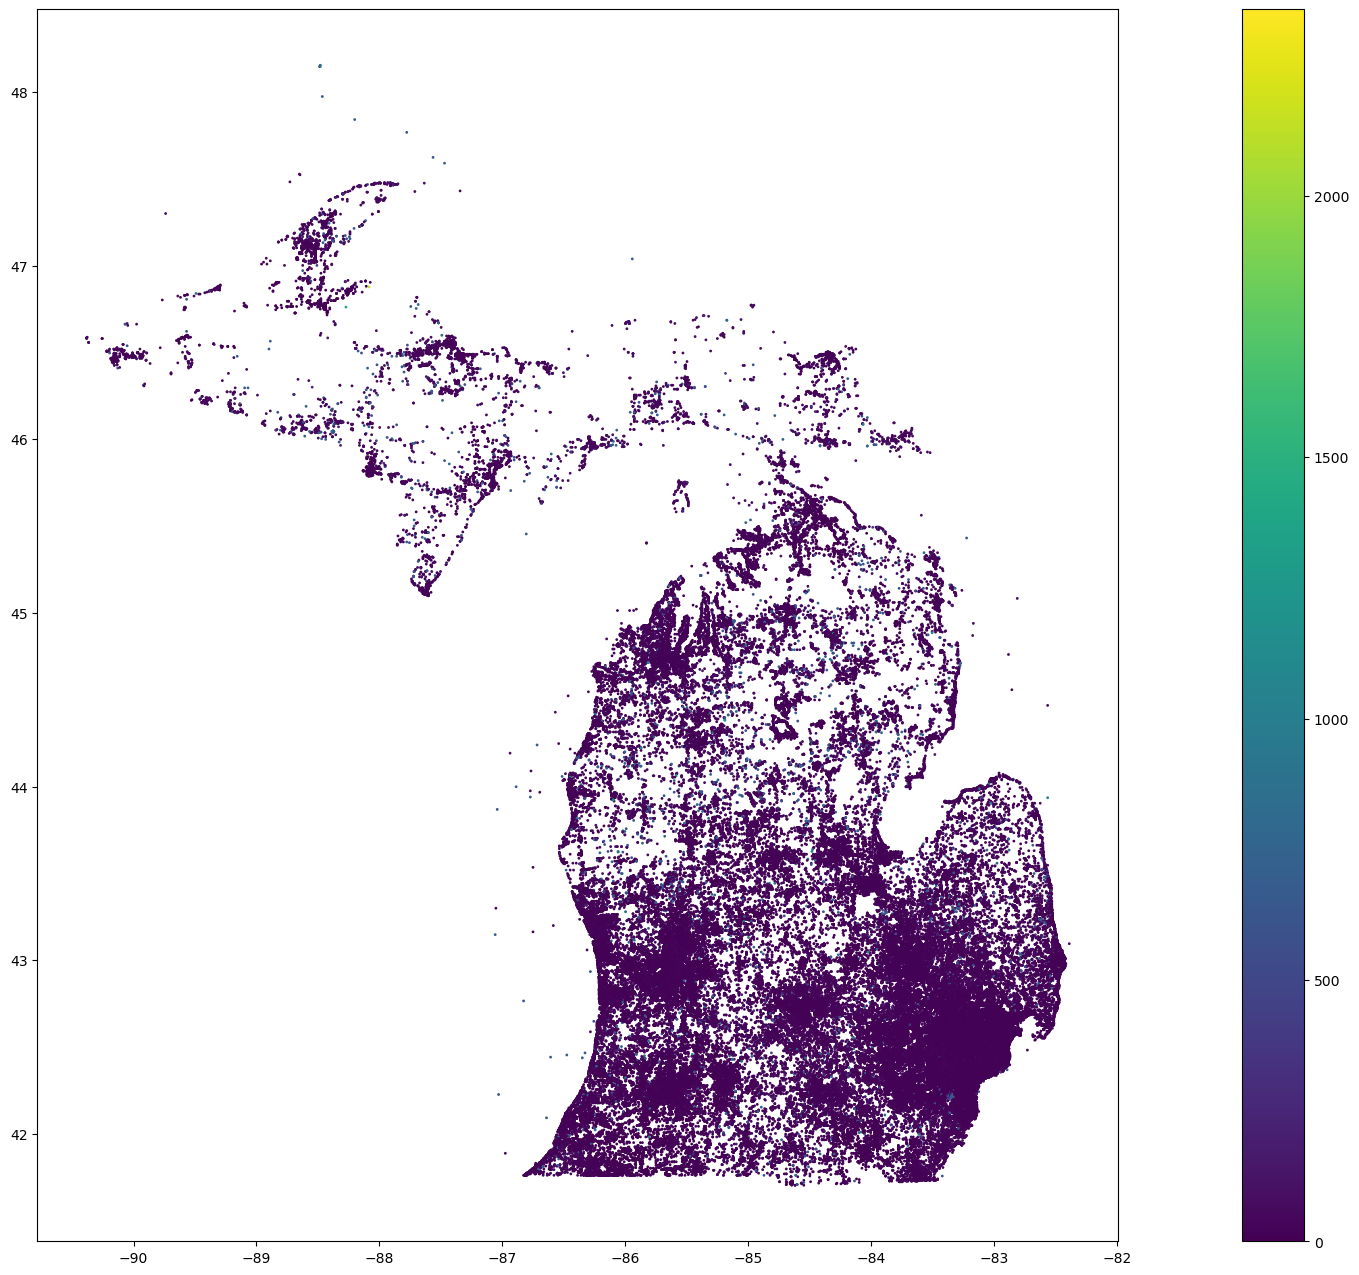

In [61]:
counties_tiles_gdf.plot(counties_tiles_gdf['avg_lat_ms'], figsize=(32, 16), markersize=1, legend=True)

## Aggregating Loaded Latency
With the dataset we created, we can now perform analysis as needed. With this example we thought to demonstrate aggregating loaded latency, since it is a recently added metric.

Group by county and calculate the weighted average of the metric.

In [10]:
county_stats = (
    counties_tiles_gdf.groupby(["GEOID"])
    .apply(
        lambda x: pd.Series(
            {"avg_metric_wt": np.average(x[metric_name], weights=x["tests"])}
        )
    )
    .reset_index()
)

/tmp/ipykernel_29185/3457767698.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


Re-merge the county polygon geometries to our data so we can visualize it

In [11]:
county_data = state_counties_gdf[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(counties.crs.to_epsg())

"Cut" the data into buckets for visualization.

In [12]:
labels = ["0 to 300", "300 to 350", "350 to 400", "400 to 450", "450+"]
county_data['group'] = pd.cut(
    county_data['avg_metric_wt'],
    bins=(0, 300, 350, 400, 450, 10000),
    right=False,
    labels=labels
)

Plot the map.

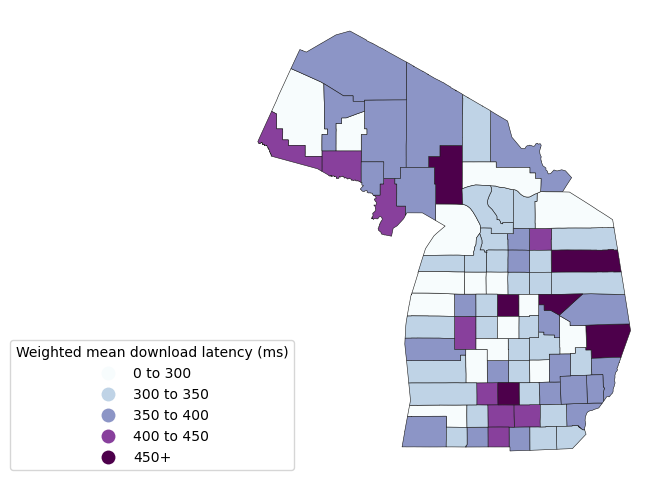

fin


In [13]:
fig, ax = plt.subplots(1, figsize=(10, 6))
county_data.plot("group", ax=ax, cmap="BuPu", linewidth=0.4, edgecolor="0.1", legend=True,)
ax.set_axis_off()

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.15, 0.3))
leg.set_title("Weighted mean download latency (ms)")

plt.show()

print("fin")